# Imports

In [2]:
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import InputLayer, Dense, Rescaling, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Shallow Autoencoder - CelebA

Visualizar o encoding e decoding de rostos humanos, usando um autoencoder raso e o dataset CelebA (+200.000 amostras) \
Dataset disponível em: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset

## Carregamento do dataset e divisão em treino, validação e teste

In [ ]:
# Carregamento do dataset via arquivo zip
caminho_arquivo = '/content/drive/MyDrive/projetos/celebA_autoencoders/CelebA_images.zip'
pasta_destino = '/content/celebA_dataset'

with zipfile.ZipFile(caminho_arquivo, 'r') as z:
  z.extractall(pasta_destino)

In [ ]:
# Divisão em base de treino e validação
full_train = image_dataset_from_directory(
    directory='/content/celebA_dataset',
    label_mode=None,
    seed=111,
    batch_size=32,
    image_size=(45, 55),
    validation_split=0.1,
    subset='training',
    shuffle=False
)

val_ds = image_dataset_from_directory(
    directory='/content/celebA_dataset',
    label_mode=None,
    seed=111,
    batch_size=32,
    image_size=(45, 55),
    validation_split=0.1,
    subset='validation',
    shuffle=False
)

# Pegando parte do treino como teste
test_size = 0.2
test_ds = full_train.take(int(len(full_train) * test_size))
train_ds = full_train.skip(int(len(full_train) * test_size))

# Treino -> 72%
# Teste  -> 18%
# Val    -> 10%

Found 202599 files.
Using 182340 files for training.
Found 202599 files.
Using 20259 files for validation.


In [ ]:
print('- ' * 10)
print(f'{int(len(train_ds) * 32)} - {int(len(train_ds) * 32) / 202599:.2%}')
print(f'{int(len(test_ds) * 32)} - {int(len(test_ds) * 32) / 202599:.2%}')
print(f'{int(len(val_ds) * 32)} - {int(len(val_ds) * 32) / 202599:.2%}')

- - - - - - - - - - 
145920 - 72.02%
36448 - 17.99%
20288 - 10.01%


## Normalização dos valores

In [ ]:
# Normaliza os valores dos pixels na escala [0,1]
def normaliza_ds(image):
  image = tf.cast(image, tf.float32) / 255
  return image

train_ds = train_ds.map(normaliza_ds, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(normaliza_ds, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(normaliza_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

## Valores para 1D array

In [ ]:
train_ds = train_ds.map(lambda x: tf.reshape(x, (tf.shape(x)[0], -1)))
test_ds = test_ds.map(lambda x: tf.reshape(x, (tf.shape(x)[0], -1)))
val_ds = val_ds.map(lambda x: tf.reshape(x, (tf.shape(x)[0], -1)))

In [ ]:
print(next(iter(train_ds.take(1))).shape)
print(next(iter(test_ds.take(1))).shape)
print(next(iter(val_ds.take(1))).shape)

(32, 7425)
(32, 7425)
(32, 7425)


In [ ]:
train_ds = train_ds.map(lambda x: (x, x))
test_ds = val_ds.map(lambda x: (x, x))
val_ds = val_ds.map(lambda x: (x, x))

## Definição do Shallow Autoencoder

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=4,
    factor=.5,
)

In [ ]:
shallow_autoencoder = Sequential([
    InputLayer(shape=(7425,)),
    Dense(units=(256)),
    Dense(units=(7425), activation='sigmoid')
])

In [ ]:
shallow_autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
shallow_autoencoder.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │     1,901,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7425)           │     1,908,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,809,281 (14.53 MB)

 Trainable params: 3,809,281 (14.53 MB)

 Non-trainable params: 0 (0.00 B)

## Treinamento do autoencoder

In [ ]:
history = shallow_autoencoder.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[early_stopping, reduce_lr])

## Salvamento e carregamento do AE

In [ ]:
shallow_autoencoder.save('shallow_autoencoder.keras')

In [13]:
shallow_autoencoder = tf.keras.models.load_model('/content/drive/MyDrive/projetos/celebA_autoencoders/shallow_autoencoder/shallow_autoencoder.keras')

## Definição do encoder

In [14]:
encoder = Sequential(shallow_autoencoder.layers[:1])

## Gráficos e visualização

In [15]:
fixed_samples = np.load('/content/drive/MyDrive/projetos/celebA_autoencoders/fixed_samples.npy')

fixed_samples = tf.reshape(fixed_samples, (-1, 178, 218, 3)) # (10, 178, 218, 3)
fixed_samples = tf.image.resize(fixed_samples, (45, 55)) # (10, 45, 55, 3)
fixed_samples = tf.reshape(fixed_samples, (5, 2, -1)).numpy() # (5, 2, 7425)

In [16]:
fixed_samples.shape

(5, 2, 7425)

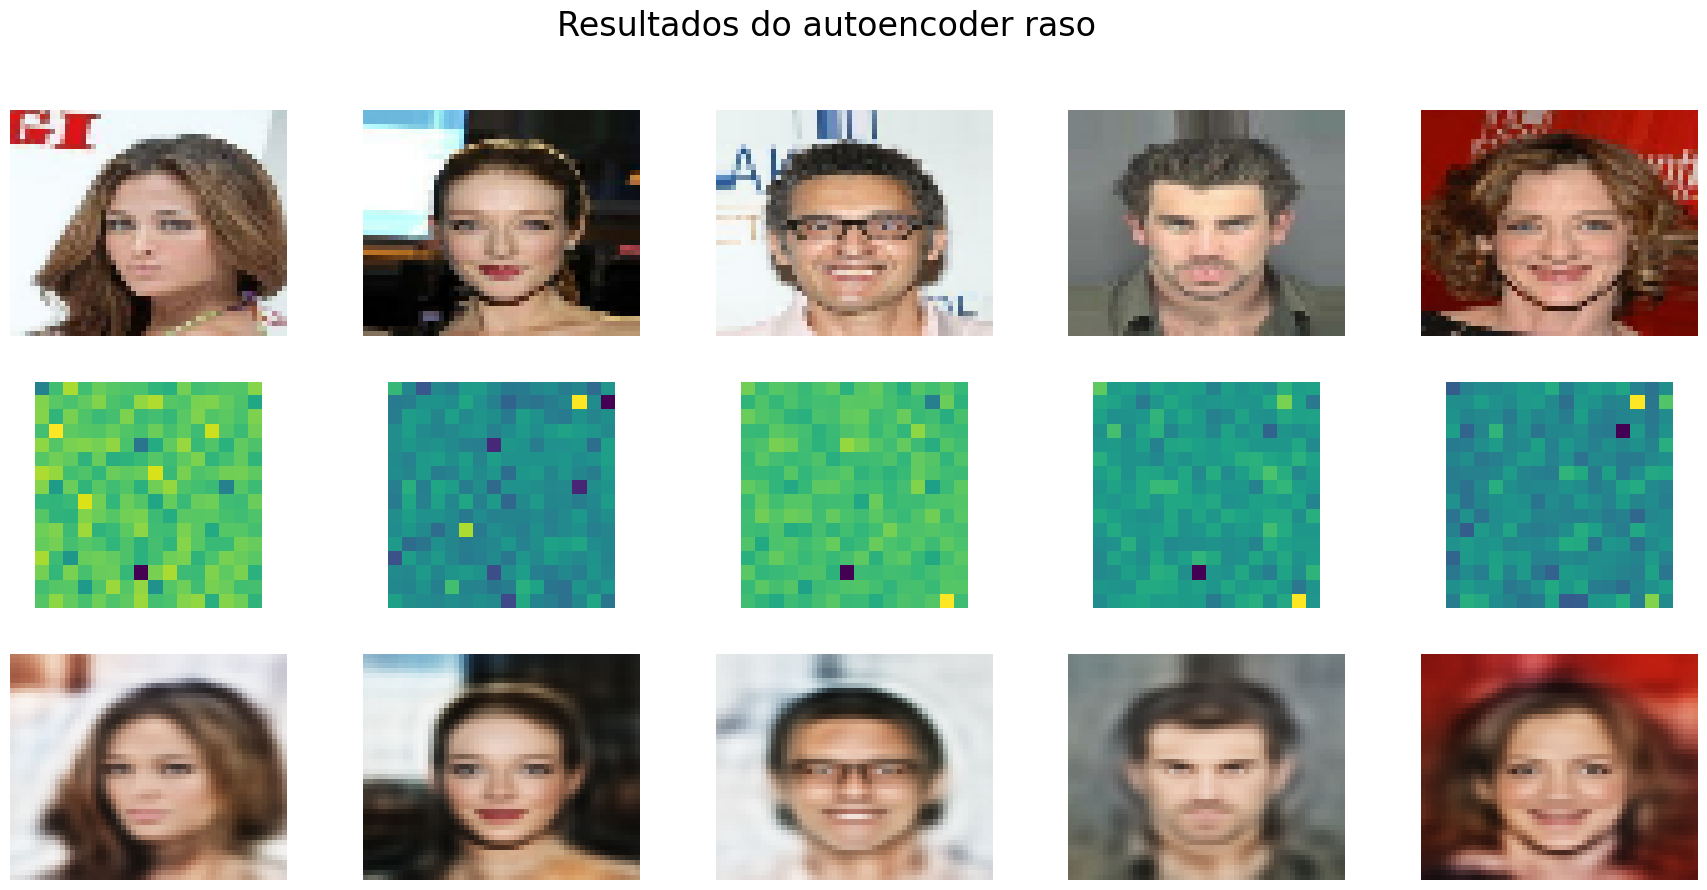

In [17]:
samples = fixed_samples
plt.figure(figsize=(22, 10))
for i, (im, _) in enumerate(samples):
  im = tf.expand_dims(im, axis=0)
  latent = encoder.predict(im, verbose=False)
  decoded = shallow_autoencoder.predict(im, verbose=False)
  decoded = tf.clip_by_value(decoded, 0, 1)

  plt.suptitle('Resultados do autoencoder raso', fontsize=24)

  plt.subplot(3, 5, i+1)
  plt.imshow(tf.reshape(im, (45, 55, 3)))
  plt.axis('off')

  plt.subplot(3, 5, i+6)
  plt.imshow(tf.reshape(latent, (16, 16)), cmap='viridis')
  plt.axis('off')

  plt.subplot(3, 5, i+11)
  plt.imshow(tf.reshape(decoded, (45, 55, 3)))
  plt.axis('off')

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

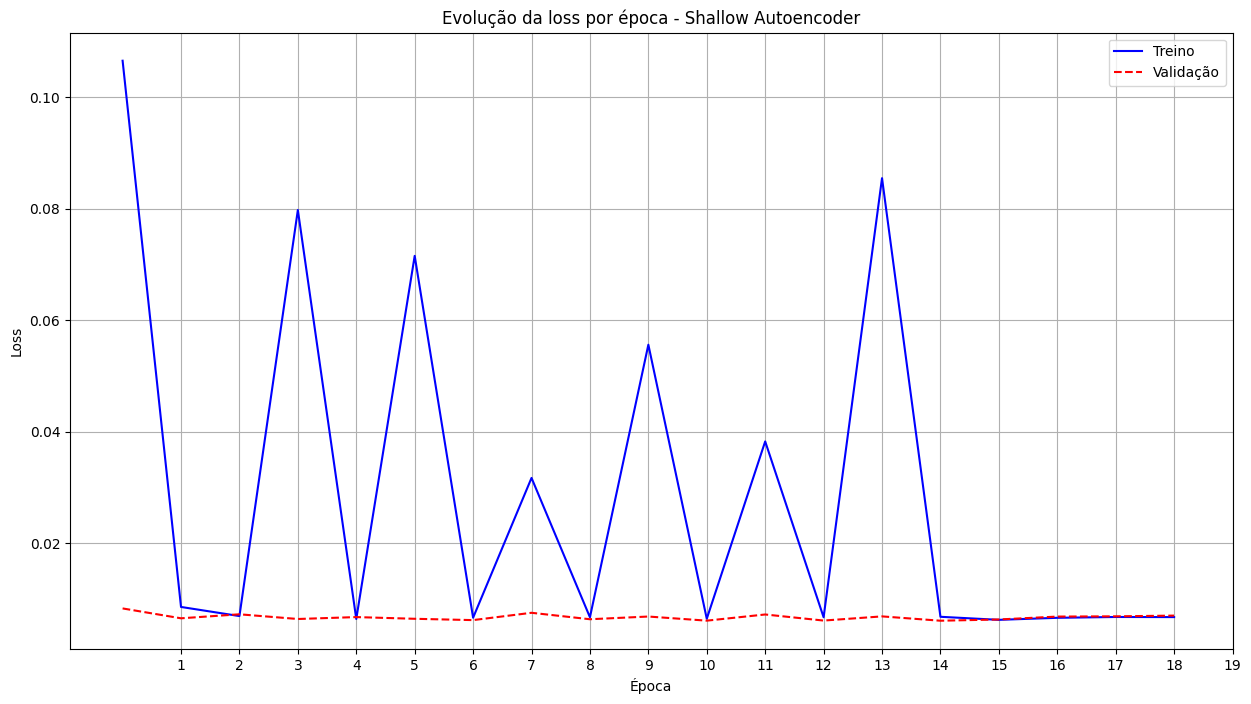

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(loss, 'b-', label='Treino')
plt.plot(val_loss, 'r--', label='Validação')
plt.xticks(epochs)
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Evolução da loss por época - Shallow Autoencoder')
plt.legend()
plt.grid(True)
plt.show();